In [1]:
# from netgen.meshing import *
# from netgen.csg import *
from dataclasses import dataclass
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# from ngsolve import ngsglobals
# ngsglobals.msg_level = 2

# from ngsolve import Draw
# import netgen.gui
# %gui tk

In [2]:
# Good
# https://pypi.org/project/pygmsh/

## Functions

In [3]:
@dataclass
class PyEITMesh3D:
    node: np.ndarray
    element: np.ndarray
    vertex: np.ndarray
    perm_array: np.ndarray
    el_pos: None


@dataclass
class PyEITAnomaly_Circle:
    center: Union[np.ndarray, list]
    perm: "float" = 1.0
    r: "float" = 0.1


@dataclass
class PyEITAnomaly_Ball:
    center: Union[np.ndarray, list]
    perm: "float" = 1.0
    r: "float" = 0.1


@dataclass
class PyEITAnomaly_Cylinder:
    center: Union[np.ndarray, list]
    perm: "float" = 1.0
    r: "float" = 10
    h: "float" = 50


def load_mesh(path: str) -> PyEITMesh3D:
    """
    load a .mesh file and return the PyEITMesh3d dataclass object.
    """

    el_pos = None

    with open(path) as f:
        lines = f.readlines()
    l1 = int(lines[0].split()[0])
    l2 = int(lines[l1 + 1].split()[0])

    node = np.array(
        [[float(val) for val in values.split()] for values in lines[1 : l1 + 1]]
    )
    element = (
        np.array(
            [
                [int(val) for val in values.split()]
                for values in lines[l1 + 2 : l1 + l2 + 2]
            ]
        )
        - 1
    )
    vertex = (
        np.array(
            [[int(val) for val in values.split()] for values in lines[l1 + l2 + 3 :]]
        )
        - 1
    )
    perm = np.ones(element.shape[0])

    return PyEITMesh3D(node, element[:, 1:], vertex, perm, el_pos)


def plot_elements_2d(mesh: PyEITMesh3D, s: float = 10) -> None:
    x = mesh.node[:, 0]
    y = mesh.node[:, 1]
    plt.scatter(x, y, s=s)
    for eles in mesh.element:
        x_f = mesh.node[eles][:, 0]
        y_f = mesh.node[eles][:, 1]
        plt.fill(x_f, y_f, color="blue", alpha=0.1)
    plt.show()


def plot_nodes_3d(mesh: PyEITMesh3D, elev: int = 10, azim: int = 10) -> None:
    x = mesh.node[:, 0]
    y = mesh.node[:, 1]
    z = mesh.node[:, 2]

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x, y, z, marker="o")

    # Set labels for the axes
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")

    ax.view_init(elev=elev, azim=azim)

    plt.show()


def plot_3d_anomaly_Ball(
    mesh: PyEITMesh3D, anomaly: PyEITAnomaly_Ball, elev: int = 10, azim: int = 10
) -> None:
    x = mesh.node[:, 0]
    y = mesh.node[:, 1]
    z = mesh.node[:, 2]

    u = np.linspace(0, 2 * np.pi, 10)
    v = np.linspace(0, np.pi, 10)
    x_c = anomaly.center[0] + anomaly.r * np.outer(np.cos(u), np.sin(v))
    y_c = anomaly.center[1] + anomaly.r * np.outer(np.sin(u), np.sin(v))
    z_c = anomaly.center[2] + anomaly.r * np.outer(np.ones(np.size(u)), np.cos(v))

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x, y, z, marker="o")
    ax.plot_surface(x_c, y_c, z_c, color="C1", alpha=0.3)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")

    ax.view_init(elev=elev, azim=azim)

    plt.show()


def set_perm_circle_2D(
    mesh_obj: PyEITMesh3D, anomaly: PyEITAnomaly_Circle
) -> PyEITMesh3D:
    pts = mesh_obj.element
    tri = mesh_obj.node
    perm = mesh_obj.perm_array
    tri_centers = np.mean(tri[pts], axis=1)
    index = (
        np.sqrt(
            (tri_centers[:, 1] - anomaly.center[1]) ** 2
            + (tri_centers[:, 0] - anomaly.center[0]) ** 2
        )
        < anomaly.r
    )

    mesh_obj.perm_array[index] = anomaly.perm  # Zuweisen von 10

    return mesh_obj


def set_perm_ball_3D(
    mesh_obj: PyEITMesh3D, anomaly: PyEITAnomaly_Circle
) -> PyEITMesh3D:
    pts = mesh.element
    tri = mesh.node
    perm = mesh.perm_array
    tri_centers = np.mean(tri[pts], axis=1)
    index = (
        np.sqrt(
            (tri_centers[:, 0] - anomaly.center[0]) ** 2
            + (tri_centers[:, 1] - anomaly.center[1]) ** 2
            + (tri_centers[:, 2] - anomaly.center[2]) ** 2
        )
        < anomaly.r
    )

    mesh_obj.perm_array[index] = anomaly.perm

    return mesh_obj


def plot_2D_mesh(mesh_obj: PyEITMesh3D, figsize: tuple = (6, 4), title: str = "mesh"):
    """
    Plot a PyEITMesh3D

    Parameters
    ----------
    mesh : PyEITMesh3D

    """
    plt.style.use("default")
    pts = mesh_obj.node
    tri = mesh_obj.element
    x, y = pts[:, 0], pts[:, 1]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.tripcolor(
        x,
        y,
        tri,
        np.real(mesh_obj.perm_array),
        edgecolors="k",
        shading="flat",
        alpha=0.5,
        cmap=plt.cm.viridis,
    )
    ax.set_title(title)
    ax.set_aspect("equal")
    fig.set_size_inches(6, 6)
    plt.show()

# 2D Meshing

In [4]:
mesh = load_mesh(path="../3d/2d_square_fine.mesh")

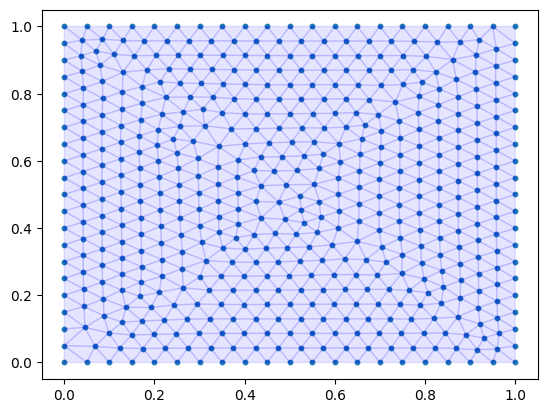

In [5]:
plot_elements_2d(mesh)

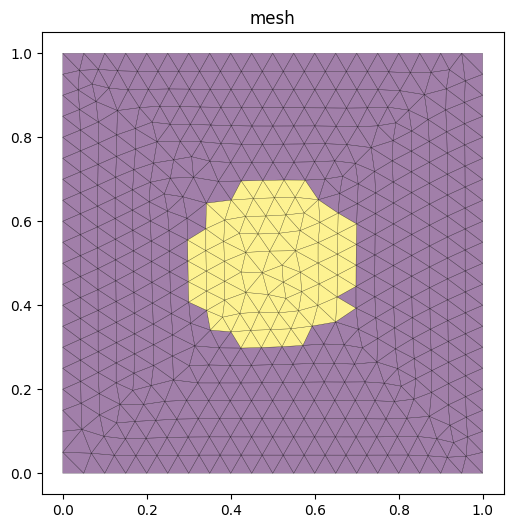

In [6]:
anmly = PyEITAnomaly_Circle(center=[0.5, 0.5], perm=3, r=0.2)

_ = set_perm_circle_2D(mesh, anmly)
plot_2D_mesh(mesh)

# 3D Meshing - Ball

In [24]:
mesh = load_mesh(path="../3d/32x2_tank_volume_mesh.mesh")
# mesh = load_mesh(path="../3d/32x2_rough.mesh")

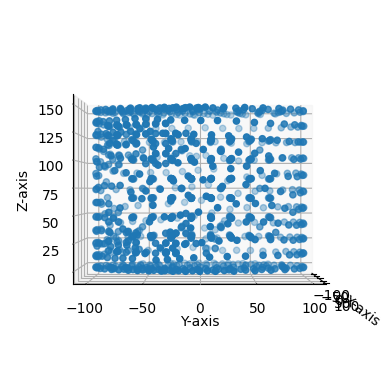

In [25]:
plot_nodes_3d(mesh, elev=0, azim=0)

In [26]:
anomaly = PyEITAnomaly_Ball(center=[0, 0, 50], perm=10, r=50)
print(anomaly)

PyEITAnomaly_Ball(center=[0, 0, 50], perm=10, r=50)


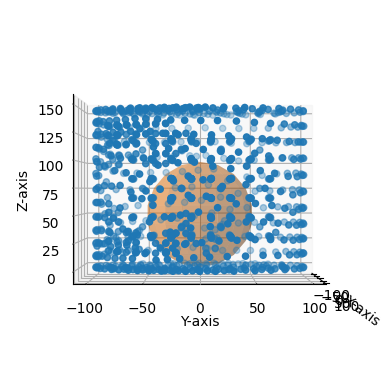

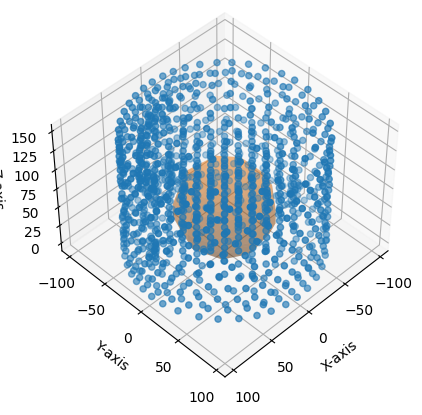

In [27]:
plot_3d_anomaly_Ball(mesh, anomaly, elev=0, azim=0)
plot_3d_anomaly_Ball(mesh, anomaly, elev=45, azim=45)

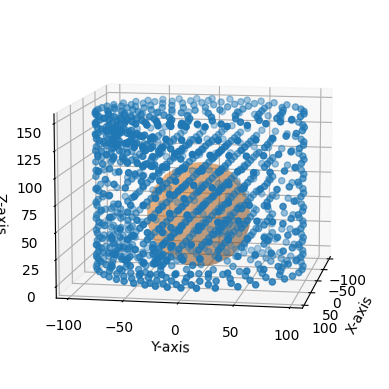

In [28]:
mesh = set_perm_ball_3D(mesh, anomaly)
plot_3d_anomaly_Ball(mesh, anomaly)

# 3D Meshing - Cylinder

In [95]:
mesh = load_mesh(path="../3d/32x2_tank_volume_mesh.mesh")
# mesh = load_mesh(path="../3d/32x2_rough.mesh")

In [96]:
anomaly = PyEITAnomaly_Cylinder(center=[0, 0, 50], perm=10, r=40, h=100)
anomaly

PyEITAnomaly_Cylinder(center=[0, 0, 50], perm=10, r=40, h=100)

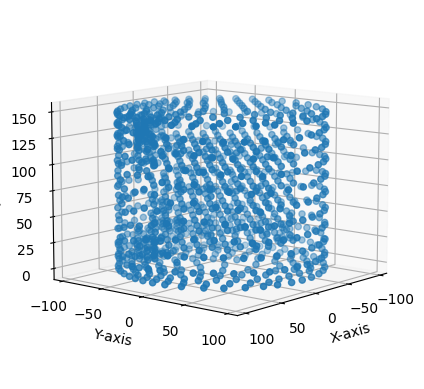

In [97]:
plot_nodes_3d(mesh, elev=10, azim=40)

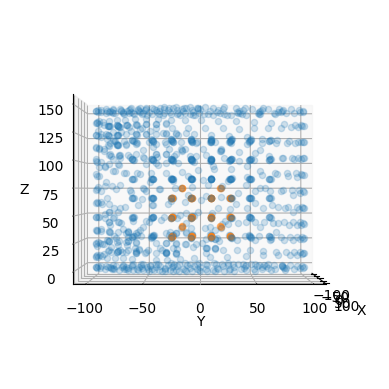

In [139]:
anomaly = PyEITAnomaly_Cylinder(center=[0, 0, 50], perm=10, r=40, h=50)


x = mesh.node[:, 0]
y = mesh.node[:, 1]
z = mesh.node[:, 2]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

doc = {"xs": [], "ys": [], "zs": [], "idx": []}
idx = 0
for xs, ys, zs in zip(x, y, z):
    if (
        np.sqrt(xs**2 + ys**2) < anomaly.r
        and zs <= anomaly.center[2] + anomaly.h / 2
        and zs >= anomaly.center[2] - anomaly.h / 2
    ):
        ax.scatter(xs, ys, zs, marker="o", c="C1", alpha=0.5)
        doc["xs"].append(xs)
        doc["ys"].append(ys)
        doc["zs"].append(zs)
        doc["idx"].append(idx)
    else:
        ax.scatter(xs, ys, zs, marker="o", c="C0", alpha=0.2)

    idx += 1

# Set labels for the axes
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.view_init(elev=0, azim=0)

plt.show()

mesh.perm_array = np.ones(len(mesh.node))

In [140]:
len(mesh.perm_array)

1118

In [141]:
mesh.perm_array[doc["idx"]] = 10

In [145]:
mesh.perm_array[624]

1.0

- [ ] Create point clound file for Meshing and generating of geometries

In [127]:
print(np.max(doc["zs"]))
print(np.min(doc["zs"]))
print("diff", np.max(doc["zs"]) - np.min(doc["zs"]))

74.723587
29.12487
diff 45.59871699999999


In [135]:
len(mesh.node)

1118

In [134]:
mesh.node[703]

array([10.985558, -7.825043, 65.603844])

## Old stuff

## TBD

- [ ] Create different object geometries for meshing using Netgen.

In [11]:
# https://inverselight.github.io/ValoMC/threedmodel.html